<a href="https://colab.research.google.com/github/Jessicashenone/dissertation/blob/main/topic_analysis_LDA_dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U jupyter_client ipykernel
!pip install numpy==1.23.5
!pip install gensim

  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!pip install contractions
import re
import string
import contractions
import nltk
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
import gensim
from gensim.utils import simple_preprocess
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df = pd.read_csv("/content/final_sentiment.csv")

In [ ]:
target_column = 'translated_comment'

In [ ]:
# remove contraction
!pip install contractions
import contractions
df[target_column] = df[target_column].map(lambda x: contractions.fix(x))

# Remove unwanted characters/objects (e.g. url, email, emoji etc.). You don't need to run all of them, but just take the ones suitable for your case.
# import the re library. Re is a built-in python package, which can be used to work with Regular Expressions.

import re

# convert the relevant column to lowercase
df[target_column] = df[target_column].str.lower()

# Remove emoji
# First, build a list of commonly used emojis
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

# Then remove the emoji
df[target_column] = df[target_column].map(lambda x: re.sub(emoj, ' ', x))

# Remove non-word characters, so numbers and ___ etc
df[target_column] = df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1670007110.py:44: SyntaxWarning: invalid escape sequence '\s'
  df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))


In [ ]:
# create a list of the contents from the 'contents' column
words = df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

from nltk.corpus import stopwords

default_stopwords = stopwords.words('english')
custom_stopwords = [
    'definitely', 'always', 'get', 'love', 'go', 'come', 'back', 'never', 'yes', 'no',"win",
    'well','thank', 'say', 'thing', 'great', 'really', 'also', 'want',"shit","horrible","beautiful","amazing","comment","ever",
    'make', 'nice', 'try', 'see', 'sport', 'nike', 'adidas', 'puma', 'reebok',"good",
    'under armour', 'think', 'ad', 'commercial',"video"
]

combined_stopwords = set(default_stopwords + custom_stopwords)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc), deacc=True)
         if word not in combined_stopwords]
        for doc in texts
    ]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
df['cleaned_review'] = rejoin

In [ ]:
df.head()

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,pred_label,prob_neg,prob_neu,prob_pos,cleaned_review
0,-78WBnpqJUw,Too official to ever need validating but we pr...,You go Gurl! ❤❤❤,9,2025-03-11T08:24:21Z,4,cy,you go gurl,2,0.000769,0.001944,0.997287,
1,-78WBnpqJUw,Too official to ever need validating but we pr...,i bet she’s a really good hip hop artist but s...,5,2025-03-10T20:44:15Z,29,en,i bet she is a really good hip hop artist but ...,1,0.161376,0.725359,0.113265,hip artist know know none nomination make acco...
2,-78WBnpqJUw,Too official to ever need validating but we pr...,Hol up hol up Doechii got a Nike deal?!?!? Ins...,31,2025-03-10T20:35:51Z,16,en,hol up hol up doechii got a nike deal instant ...,1,0.423621,0.535507,0.040873,hol hol doechii get deal instant classic gettt...
3,17aYq81IENc,Morning | Nike,esse anúncio é bom demais,2,2025-03-14T18:16:06Z,5,pt,this ad is too good,2,0.001404,0.001449,0.997147,
4,17aYq81IENc,Morning | Nike,What's the song name ?,2,2025-01-19T02:38:28Z,5,en,what is the song name,1,0.013336,0.970276,0.016388,


In [ ]:
import matplotlib.pyplot as plt


df['review_len'] = df['cleaned_review'].apply(lambda x: len(str(x).split()))


print(df['review_len'].describe())


count    1783.000000
mean        4.048794
std         5.011477
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        71.000000
Name: review_len, dtype: float64


In [ ]:
df = df[df['cleaned_review'].apply(lambda x: len(str(x).split()) >= 1)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1563 entries, 1 to 1782
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            1563 non-null   object 
 1   video_title         1563 non-null   object 
 2   comment             1563 non-null   object 
 3   like_count          1563 non-null   int64  
 4   published_at        1563 non-null   object 
 5   comment_len         1563 non-null   int64  
 6   language            1563 non-null   object 
 7   translated_comment  1563 non-null   object 
 8   pred_label          1563 non-null   int64  
 9   prob_neg            1563 non-null   float64
 10  prob_neu            1563 non-null   float64
 11  prob_pos            1563 non-null   float64
 12  cleaned_review      1563 non-null   object 
 13  review_len          1563 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 183.2+ KB


In [ ]:
df.isnull().sum()

,0
video_id,0
video_title,0
comment,0
like_count,0
published_at,0
comment_len,0
language,0
translated_comment,0
pred_label,0
prob_neg,0


In [ ]:
df.to_csv('finsentiment_lemm.csv', index=False)

In [ ]:
df_negative = df[df['pred_label'] == 0 ].copy()
df_negative.head()

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,pred_label,prob_neg,prob_neu,prob_pos,cleaned_review,review_len
16,17aYq81IENc,Morning | Nike,Bone Thugs en la casa!,8,2024-09-23T05:53:19Z,5,es,bone thugs at home,0,0.966885,0.031432,0.001683,home,1
22,17aYq81IENc,Morning | Nike,Definitely wasn't expecting to hear Bone Thugs...,49,2024-09-16T20:25:18Z,11,en,definitely was not expecting to hear bone thug...,0,0.980233,0.018756,0.001011,expect hear harmony,3
35,1MZtPGXkM4g,The Only Way is Through: Cam Newton,Did they buy some view because the number of c...,15,2020-11-12T05:52:21Z,15,en,did they buy some view because the number of c...,0,0.886548,0.112108,0.001343,buy view number comment like add,6
69,32__plJ-Q_Y,Summer of Sport Anthem Film | adidas,Trash,1,2024-07-24T14:20:54Z,1,en,trash,0,0.986197,0.011470,0.002333,trash,1
81,60VUmjxuDLY,WINNING ISN’T FOR EVERYONE | FACE | QINWEN ZHENG,Pure Talent > Nepotism \n\nIs anyone surprise ...,11,2024-08-02T16:08:48Z,34,en,pure talent nepotism is anyone surprise that n...,0,0.914902,0.075643,0.009455,pure talent nepotism surprise daughter cry com...,13


100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

k=2, coherence=0.4605
k=3, coherence=0.4741
k=4, coherence=0.5097
k=5, coherence=0.4751
k=6, coherence=0.4860
k=7, coherence=0.4628
k=8, coherence=0.4588
k=9, coherence=0.4481
k=10, coherence=0.4542


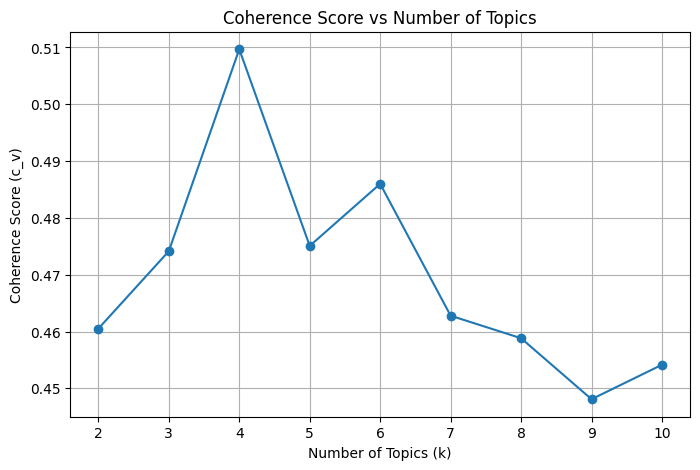

In [ ]:
#Coherence vs K only

import pandas as pd
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
from tqdm import tqdm

# Tokenization
df_negative['tokens'] = df_negative['cleaned_review'].apply(lambda x: x.split())

# Dictionary + Corpus
dictionary = corpora.Dictionary(df_negative['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_negative['tokens']]

# Coherence evaluation
def compute_coherence_values(dictionary, corpus, texts, k_range, passes=10):
    coherence_values = []
    models = []

    for k in tqdm(k_range):
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=42,
                             passes=passes,
                             alpha='auto',
                             eta='auto')

        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence)
        models.append(lda_model)

    return models, coherence_values

# Set k range
k_range = list(range(2, 11))
models, coherences = compute_coherence_values(dictionary, corpus, df_negative['tokens'], k_range)

#print k and coherence
for k, c in zip(k_range, coherences):
    print(f"k={k}, coherence={c:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, coherences, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score (c_v)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# Manually  Best K

best_k= 4
lda_neg = LdaModel(corpus=corpus,
                      id2word=dictionary,
                      num_topics=best_k,
                      random_state=30,
                      passes=15,
                      iterations=300,
                      alpha='asymmetric',
                      eta='auto',
                      chunksize=100,
                      minimum_probability=0.01)

# check the topic words
def print_top_words(model, num_words=15):
    for idx in range(model.num_topics):
        topic_words = ", ".join([word for word, prob in model.show_topic(idx, topn=num_words)])
        print(f"Topic {idx+1}: {topic_words}")

print("Top Keywords per Topic:")
print_top_words(lda_neg, num_words=15)

Top Keywords per Topic:
Topic 1: bad, song, sport, give, respect, buy, see, music, know, hear, comment, man, put, hard, want
Topic 2: lose, people, take, well, trait, sportsmanship, bad, game, leave, year, empathy, self, human, come, commercial
Topic 3: bad_person, hate, athlete, world, wrong, win, make, answer, evil, good, describe, awful, much, ask, become
Topic 4: go, message, still, woman, need, play, watch, seem, get, olympic, thing, pay, opponent, person, say


In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim as gensimvis

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_neg, corpus, dictionary)


display(vis_data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 47.2 MB/s eta 0:00:00


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.176203 -0.093375       1        1  37.119488
1     -0.207850  0.072500       2        1  23.773324
2      0.202823 -0.239304       3        1  21.088061
3      0.181230  0.260180       4        1  18.019128, topic_info=          Term       Freq      Total Category  logprob  loglift
86  bad_person  22.000000  22.000000  Default  30.0000  30.0000
13          go  18.000000  18.000000  Default  29.0000  29.0000
21        hate  19.000000  19.000000  Default  28.0000  28.0000
18         bad  56.000000  56.000000  Default  27.0000  27.0000
27        song  32.000000  32.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
80         day   0.207658   5.666595   Topic4  -6.7798  -1.5927
55        even   0.202167   5.245282   Topic4  -6.8066  -1.5423
52        year   0.238756  10.223414   Topic4  -6.6402  -2.0433
89     empathy   0.236057   9.913235   Topic4  -6.6516  -2.0238
44       sport   0.223975  20.836503   Topic4  -6.7041  -2.8192

[172 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5         1  0.468981  advertisement
5         3  0.468981  advertisement
33        1  0.958945    advertising
10        1  0.770292   announcement
23        1  0.946259       annoying
...     ...       ...            ...
41        3  0.961760          world
25        1  0.883593          worst
96        3  0.943654          wrong
52        2  0.880332           year
83        3  0.891490           yike

[111 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [ ]:
df_positive = df[df['pred_label'] == 2 ].copy()
df_positive.head()

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,pred_label,prob_neg,prob_neu,prob_pos,cleaned_review,review_len
5,17aYq81IENc,Morning | Nike,"Juntaram duas paixões em um único comercial, n...",5,2024-12-10T02:53:02Z,14,pt,add two passions in a single commercial nike a...,2,0.000442,0.004265,0.995293,add passion single bmth crazy daddy,6
6,17aYq81IENc,Morning | Nike,Magnificent visuals. Makes your eyes wanna glu...,2,2024-12-09T12:47:14Z,14,en,magnificent visuals makes your eyes want to gl...,2,0.000878,0.004142,0.994980,magnificent visual make eye glue screen bit long,8
8,17aYq81IENc,Morning | Nike,Yup! Me in the morning 💪🏻… 83 lbs down and cou...,2,2024-10-23T03:04:02Z,13,en,yup me in the morning lbs down and counting,2,0.000388,0.007185,0.992428,morning lbs counting,3
9,17aYq81IENc,Morning | Nike,This unexpectedly made me real emotional. Like...,102,2024-10-11T01:56:18Z,13,en,this unexpectedly made me real emotional like ...,2,0.001154,0.028874,0.969973,unexpectedly make real emotional alone journey,6
11,17aYq81IENc,Morning | Nike,Nike nailed it adding legendary bone thugs,2,2024-09-29T14:53:18Z,7,en,nike nailed it adding legendary bone thugs,2,0.001240,0.017720,0.981040,nail add legendary bone_thug,4


100%|██████████| 9/9 [00:35<00:00,  3.94s/it]

k=2, coherence=0.4576
k=3, coherence=0.5041
k=4, coherence=0.5496
k=5, coherence=0.5178
k=6, coherence=0.5424
k=7, coherence=0.5552
k=8, coherence=0.5556
k=9, coherence=0.5416
k=10, coherence=0.5407


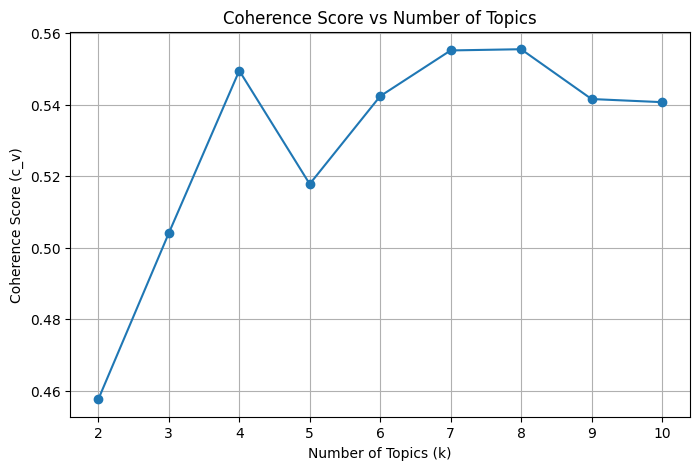

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
from tqdm import tqdm

# Tokenization
df_positive['tokens'] = df_positive['cleaned_review'].apply(lambda x: x.split())

# Dictionary + Corpus
dictionary = corpora.Dictionary(df_positive['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_positive['tokens']]

# Coherence evaluation
def compute_coherence_values(dictionary, corpus, texts, k_range, passes=10):
    coherence_values = []
    models = []

    for k in tqdm(k_range):
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=42,
                             passes=passes,
                             alpha='auto',
                             eta='auto')

        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence)
        models.append(lda_model)

    return models, coherence_values

# Set k range
k_range = list(range(2, 11))
models, coherences = compute_coherence_values(dictionary, corpus, df_positive['tokens'], k_range)

#print k and coherence
for k, c in zip(k_range, coherences):
    print(f"k={k}, coherence={c:.4f}")


# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, coherences, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score (c_v)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# Manually Best K

best_k = 4 # 👈

lda_pos = LdaModel(corpus=corpus,
                      id2word=dictionary,
                      num_topics=best_k,
                      random_state=30,
                      passes=15,
                      iterations=300,
                      alpha='asymmetric',
                      eta='auto',
                      chunksize=100,
                      minimum_probability=0.01)

# topic words
def print_top_words(model, num_words=15):
    for idx in range(model.num_topics):
        topic_words = ", ".join([word for word, prob in model.show_topic(idx, topn=num_words)])
        print(f"Topic {idx+1}: {topic_words}")

print("Top Keywords per Topic:")
print_top_words(lda_pos, num_words=15)

Top Keywords per Topic:
Topic 1: good, well, get, go, win, do, come, great, commercial, know, life, athlete, day, ant, world
Topic 2: make, ad, fire, real, inspire, finally, powerful, guy, incredible, awesome, new, lebron, true, brand, tear
Topic 3: woman, watch, time, shoe, song, work, sport, perfect, absolutely, lol, many, last, favorite, kobe, campaign
Topic 4: see, man, year, run, still, love, winner, right, well, hard, way, cool, player, hit, friend


In [ ]:
# data
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_pos, corpus, dictionary)

# display
display(vis_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.245775 -0.098993       1        1  44.649825
2      0.260724  0.114980       2        1  20.726593
1      0.105194 -0.249531       3        1  17.470038
3     -0.120143  0.233544       4        1  17.153543, topic_info=         Term       Freq      Total Category  logprob  loglift
3        make  36.000000  36.000000  Default  30.0000  30.0000
14        see  32.000000  32.000000  Default  29.0000  29.0000
77        man  26.000000  26.000000  Default  28.0000  28.0000
106     woman  28.000000  28.000000  Default  27.0000  27.0000
98      watch  25.000000  25.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
102  creative   3.181227   3.890808   Topic4  -4.5973   1.5616
149       use   6.399802   7.942207   Topic4  -3.8983   1.5470
130       run  14.014797  18.669000   Topic4  -3.1144   1.4762
20       play   2.808198   9.534825   Topic4  -4.7220   0.5406
15       well  10.634968  50.485395   Topic4  -3.3904   0.2054

[155 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
133       2  0.901016     absolutely
95        3  0.961129             ad
104       3  0.970838         advert
115       2  0.962296  advertisement
154       4  0.863853    advertising
...     ...       ...            ...
152       4  0.949399         winner
106       2  0.968530          woman
93        2  0.960686           work
55        1  0.927757          world
83        4  0.964950           year

[132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [ ]:
df_neutral = df[df['pred_label'] == 1 ].copy()
df_neutral.head()

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,pred_label,prob_neg,prob_neu,prob_pos,cleaned_review,review_len
1,-78WBnpqJUw,Too official to ever need validating but we pr...,i bet she’s a really good hip hop artist but s...,5,2025-03-10T20:44:15Z,29,en,i bet she is a really good hip hop artist but ...,1,0.161376,0.725359,0.113265,hip artist know know none nomination make acco...,9
2,-78WBnpqJUw,Too official to ever need validating but we pr...,Hol up hol up Doechii got a Nike deal?!?!? Ins...,31,2025-03-10T20:35:51Z,16,en,hol up hol up doechii got a nike deal instant ...,1,0.423621,0.535507,0.040873,hol hol doechii get deal instant classic gettt...,9
7,17aYq81IENc,Morning | Nike,"Each day is a struggle, but it's worth it at t...",3,2024-11-08T07:22:09Z,12,en,each day is a struggle but it is worth it at t...,1,0.042290,0.712497,0.245213,day struggle worth end,4
10,17aYq81IENc,Morning | Nike,Only advert I haven’t skipped.,3,2024-10-07T18:13:29Z,5,no,only advert i have not skipped,1,0.030031,0.621724,0.348245,advert skip,2
14,17aYq81IENc,Morning | Nike,Night owls who workout at night watching this: 🤔,2,2024-09-26T02:31:32Z,9,en,night owls who workout at night watching this,1,0.025232,0.968320,0.006448,night owl night watch,4


In [ ]:
df_neutral.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 1 to 1779
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            339 non-null    object 
 1   video_title         339 non-null    object 
 2   comment             339 non-null    object 
 3   like_count          339 non-null    int64  
 4   published_at        339 non-null    object 
 5   comment_len         339 non-null    int64  
 6   language            339 non-null    object 
 7   translated_comment  339 non-null    object 
 8   pred_label          339 non-null    int64  
 9   prob_neg            339 non-null    float64
 10  prob_neu            339 non-null    float64
 11  prob_pos            339 non-null    float64
 12  cleaned_review      339 non-null    object 
 13  review_len          339 non-null    int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 47.8+ KB


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

k=2, coherence=0.6324
k=3, coherence=0.6341
k=4, coherence=0.6348
k=5, coherence=0.6774
k=6, coherence=0.6859
k=7, coherence=0.6691
k=8, coherence=0.6865
k=9, coherence=0.6661
k=10, coherence=0.6788


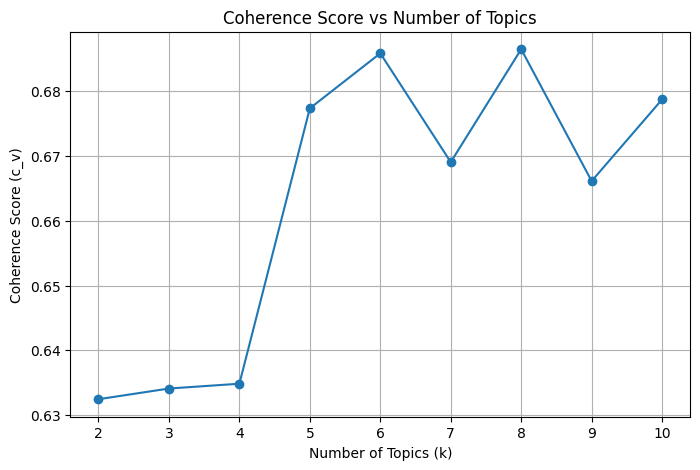

In [ ]:
# Coherence vs K

import pandas as pd
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
from tqdm import tqdm

# Tokenization
df_neutral['tokens'] = df_neutral['cleaned_review'].apply(lambda x: x.split())

# Dictionary + Corpus
dictionary = corpora.Dictionary(df_neutral['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_neutral['tokens']]

# Coherence evaluation
def compute_coherence_values(dictionary, corpus, texts, k_range, passes=10):
    coherence_values = []
    models = []

    for k in tqdm(k_range):
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=42,
                             passes=passes,
                             alpha='auto',
                             eta='symmetric')

        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence)
        models.append(lda_model)

    return models, coherence_values

# Set k range
k_range = list(range(2, 11))
models, coherences = compute_coherence_values(dictionary, corpus, df_neutral['tokens'], k_range)

#print k and coherence
for k, c in zip(k_range, coherences):
    print(f"k={k}, coherence={c:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, coherences, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score (c_v)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# Manually Best K

best_k = 5

lda_neu = LdaModel(corpus=corpus,
                      id2word=dictionary,
                      num_topics=best_k,
                      random_state=30,
                      passes=15,
                      iterations=300,
                      alpha='auto',
                      eta='auto',
                      chunksize=100,
                      minimum_probability=0.01)

# topic word
def print_top_words(model, num_words=15):
    for idx in range(model.num_topics):
        topic_words = ", ".join([word for word, prob in model.show_topic(idx, topn=num_words)])
        print(f" Topic {idx+1}: {topic_words}")

print(" Top Keywords per Topic:")
print_top_words(lda_neu, num_words=15)

 Top Keywords per Topic:
 Topic 1: go, get, athlete, music, got_high, take, ant, respect, people, come, win, day, name, need, lol
 Topic 2: first, say, leave, comment, take, look, day, ant, sport, shoe, music, athlete, win, come, get
 Topic 3: come, know, need, shoe, people, say, take, look, athlete, respect, music, win, song, get, lol
 Topic 4: win, respect, dunk, sport, think, lol, take, athlete, ant, come, lebron, go, need, get, people
 Topic 5: lebron, song, name, dunk, music, take, know, look, get, go, come, respect, athlete, say, comment


In [ ]:
# data
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_neu, corpus, dictionary)

# display
display(vis_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.116225  0.233748       1        1  25.825470
0     -0.354655  0.000965       2        1  23.105393
3      0.103734 -0.304859       3        1  18.285078
2      0.064570  0.021598       4        1  18.071635
4      0.070126  0.048548       5        1  14.712423, topic_info=       Term       Freq      Total Category  logprob  loglift
25   lebron  13.000000  13.000000  Default  27.0000  27.0000
5        go  17.000000  17.000000  Default  26.0000  26.0000
10     song  11.000000  11.000000  Default  25.0000  25.0000
1       get  15.000000  15.000000  Default  24.0000  24.0000
24      win  10.000000  10.000000  Default  23.0000  23.0000
..      ...        ...        ...      ...      ...      ...
26  respect   0.176188  10.387120   Topic5  -5.2491  -2.1603
16  athlete   0.176187  10.527965   Topic5  -5.2491  -2.1738
24      win   0.176181  10.590717   Topic5  -5.2491  -2.1797
1       get   0.176691  15.086848   Topic5  -5.2462  -2.5307
5        go   0.176434  17.473671   Topic5  -5.2477  -2.6790

[162 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
11        1  0.725853       ant
16        2  0.949851   athlete
7         4  0.886122      come
23        1  0.931270   comment
3         1  0.717016       day
22        3  0.819457      dunk
4         1  0.968486     first
1         2  0.927961       get
5         2  0.972892        go
15        2  0.715376  got_high
0         4  0.914739      know
19        1  0.883006     leave
25        5  0.962938    lebron
13        3  0.810138       lol
21        1  0.940866      look
18        2  0.817636     music
9         5  0.837507      name
12        4  0.943540      need
8         4  0.938395    people
26        3  0.962731   respect
20        1  0.875531       say
2         4  0.867993      shoe
10        5  0.917634      song
6         3  0.826196     sport
17        1  0.877999      take
14        3  0.837509     think
24        3  0.944223       win, R=27, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3, 5])